## Warning
I plan to deprecate gradient_method. Try to use gradient descent instead

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_O

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gm' in globals()
try:
    import gradient_method as gm
except:
    try:
        import Bubble_dynamics_simulation.gradient_method as gm
    except:
        print(colored(f'Error, \'gradient_method.py\' not found', 'red'))
if already_imported: importlib.reload(gm)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: no_excitation (control parameters: [])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: False


In [3]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 200.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0, 10.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    # vapour pressure [Pa] - will be calculated from T_inf
    P_v = [par.P_v],
    # dynamic viscosity [Pa*s] - will be calculated from T_inf
    mu_L = [par.mu_L],
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    # -
)

for key in gm.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

Starting the searches from random points is not a good practice. You may start them from the best points of a bruteforce search. Alternatively, you can use trial_points, and only use the best searches points as start points.

index:      894/1000;   success: False;   runtime:  42.73 [s]   |   R_E= 1.165454e-05;   ratio= 7.560890e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  2132.7 [MJ/kg])                                                                           
DONE
total time:  238.65 [s]   ( 0.24 [s/run])
best energy_efficiency:  2.132721e+03 [MJ/kg]
10th energy_efficiency:  2.266343e+03 [MJ/kg]


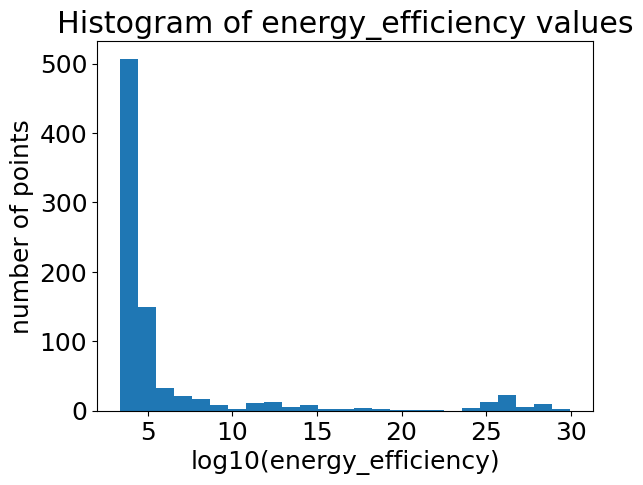

In [4]:
# create folder for parameter study results:
file = gm.de.Make_dir('D:/parameter_studies/gradient_method_test_1')
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 10    # number os total searches
trial_points = 1000  # number of trial start_points. best ones will be used for searches


kwargs_list = [
    dict(
        point=gm.rand_point(ranges, ID=i, gases=[par.index['N2'], par.index['H2']], padding=0.001),
        to_optimize=to_optimize,
        t_int=[0.0, 1.0],
        LSODA_timeout=30,
        Radau_timeout=300,
    )
for i in range(trial_points)]
best_energy_efficiency = 1e30
start_points = []

start = time.time()
file.new_file()
with Pool(processes=cpu_count()-4, maxtasksperchild=100) as pool:
    results = pool.imap_unordered(gm.evaluate_kwargs, kwargs_list)

    for result in results:
        data, point, success = result
        data = gm.de.dotdict(data)
        file.write_line(data)
        start_points.append(point)
      # print stuff:
        if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
            best_energy_efficiency = data.energy_efficiency
        to_print = [f'{key}={data[key]: e};   ' for key in ranges if len(ranges[key]) == 2]
        to_print = ''.join(to_print)
        print(f'index: {data.ID: >8}/{len(kwargs_list)};   success: {success};   runtime: {data.elapsed_time: 6.2f} [s]   |   ' + to_print + '|   ' +
              f'{gm.de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
              '                                                 ', end='\r')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\nDONE')
print(f'total time: {elapsed: .2f} [s]   ({(elapsed / len(kwargs_list)): .2f} [s/run])')

start_points.sort(key=lambda point: point['output'])
outputs = [np.log10(point['output']) for point in start_points if point['output'] < 1e30]
print(f'best energy_efficiency: {start_points[0]["output"]: e} [MJ/kg]')
print(f'{searches}th energy_efficiency: {start_points[searches-1]["output"]: e} [MJ/kg]')
plt.hist(outputs, bins=25)
plt.xlabel('log10(energy_efficiency)')
plt.ylabel('number of points')
plt.title('Histogram of energy_efficiency values')
plt.show()

In [5]:
kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=start_point,
    max_steps=200,
    first_step=0.05, #between two parameter combinations
    min_step=1e-4, #between two parameter combinations
    decay=0.5,
    learning_rate=1.0,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for start_point in start_points[:searches]]

In [6]:
"""Save settings as txt"""

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gm.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_method_settings')

In [7]:
""" Gradient method, multithread"""

best_output = 1.0e30
total_point_num = 0
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count()-6, maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gm.search, kwargs_list)
    for result in results:
        datas, best_central_values, elapsed, step_num, point_num = result
        total_point_num += point_num
        num += 1
        to_plot.append(best_central_values)
        last_points.append(gm.de.copy(datas[-1]))
        for i in range(len(datas)):
            if datas[i]['output'] < best_output:
                best_output = datas[i]['output']

        # save points
        file.new_file()
        for data in datas:
            file.write_line(data)
        file.close()
        del(datas)
        
        # print stuff:
        if point_num==0: point_num=1
        print(f'{num: <3}/{searches}: Total {len(best_central_values): <3} steps and {point_num: <4} points, finished in {elapsed: 8.2f} [s]   ({(elapsed / point_num): 4.2f} [s/run]).   '+
              f'Final {to_optimize}: {last_points[-1][to_optimize]: 8.1f} (best: {best_output: 6.1f})')

file.close()
end = time.time()  
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

1  /10: Total 41  steps and 188  points, finished in   566.47 [s]   ( 3.01 [s/run]).   Final energy_efficiency:   2130.6 (best:  2130.6)
2  /10: Total 61  steps and 264  points, finished in   757.92 [s]   ( 2.87 [s/run]).   Final energy_efficiency:   2130.4 (best:  2130.4)
3  /10: Total 64  steps and 276  points, finished in   762.73 [s]   ( 2.76 [s/run]).   Final energy_efficiency:   2130.5 (best:  2130.4)
4  /10: Total 81  steps and 340  points, finished in   900.94 [s]   ( 2.65 [s/run]).   Final energy_efficiency:   2130.5 (best:  2130.4)
5  /10: Total 81  steps and 340  points, finished in   943.08 [s]   ( 2.77 [s/run]).   Final energy_efficiency:   2131.1 (best:  2130.4)
6  /10: Total 81  steps and 340  points, finished in   968.01 [s]   ( 2.85 [s/run]).   Final energy_efficiency:   2130.6 (best:  2130.4)
7  /10: Total 101 steps and 416  points, finished in  1013.42 [s]   ( 2.44 [s/run]).   Final energy_efficiency:   2130.5 (best:  2130.4)
8  /10: Total 101 steps and 416  points, 

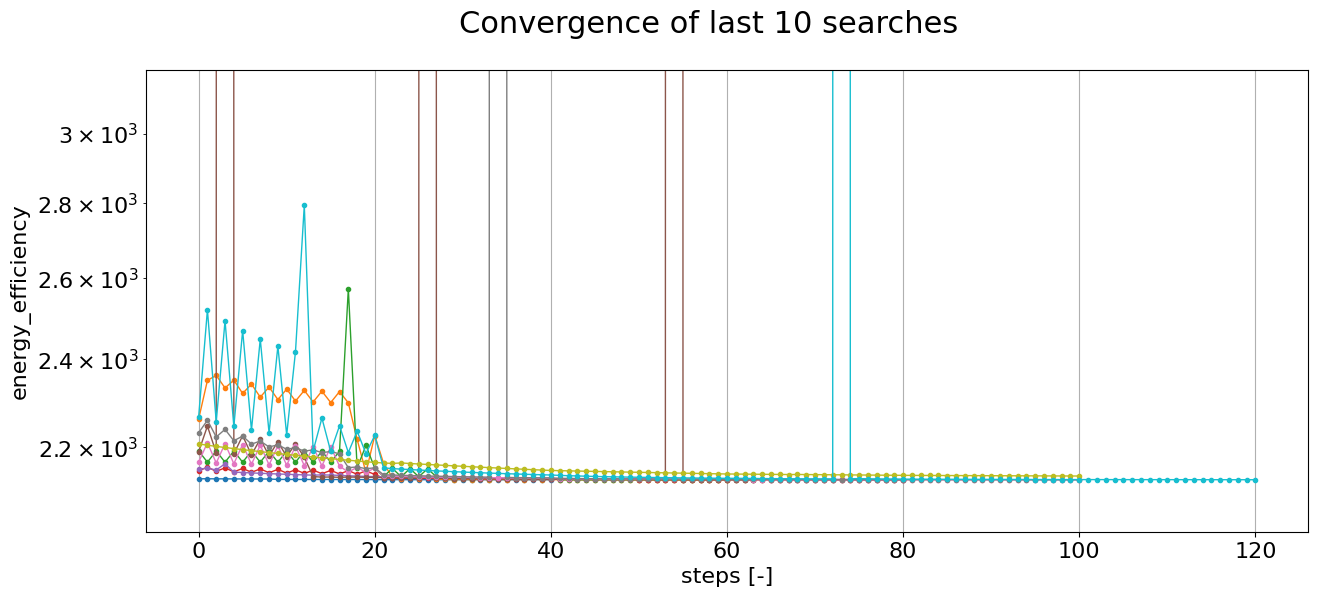

In [10]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(0.95*best_output, 1.5*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

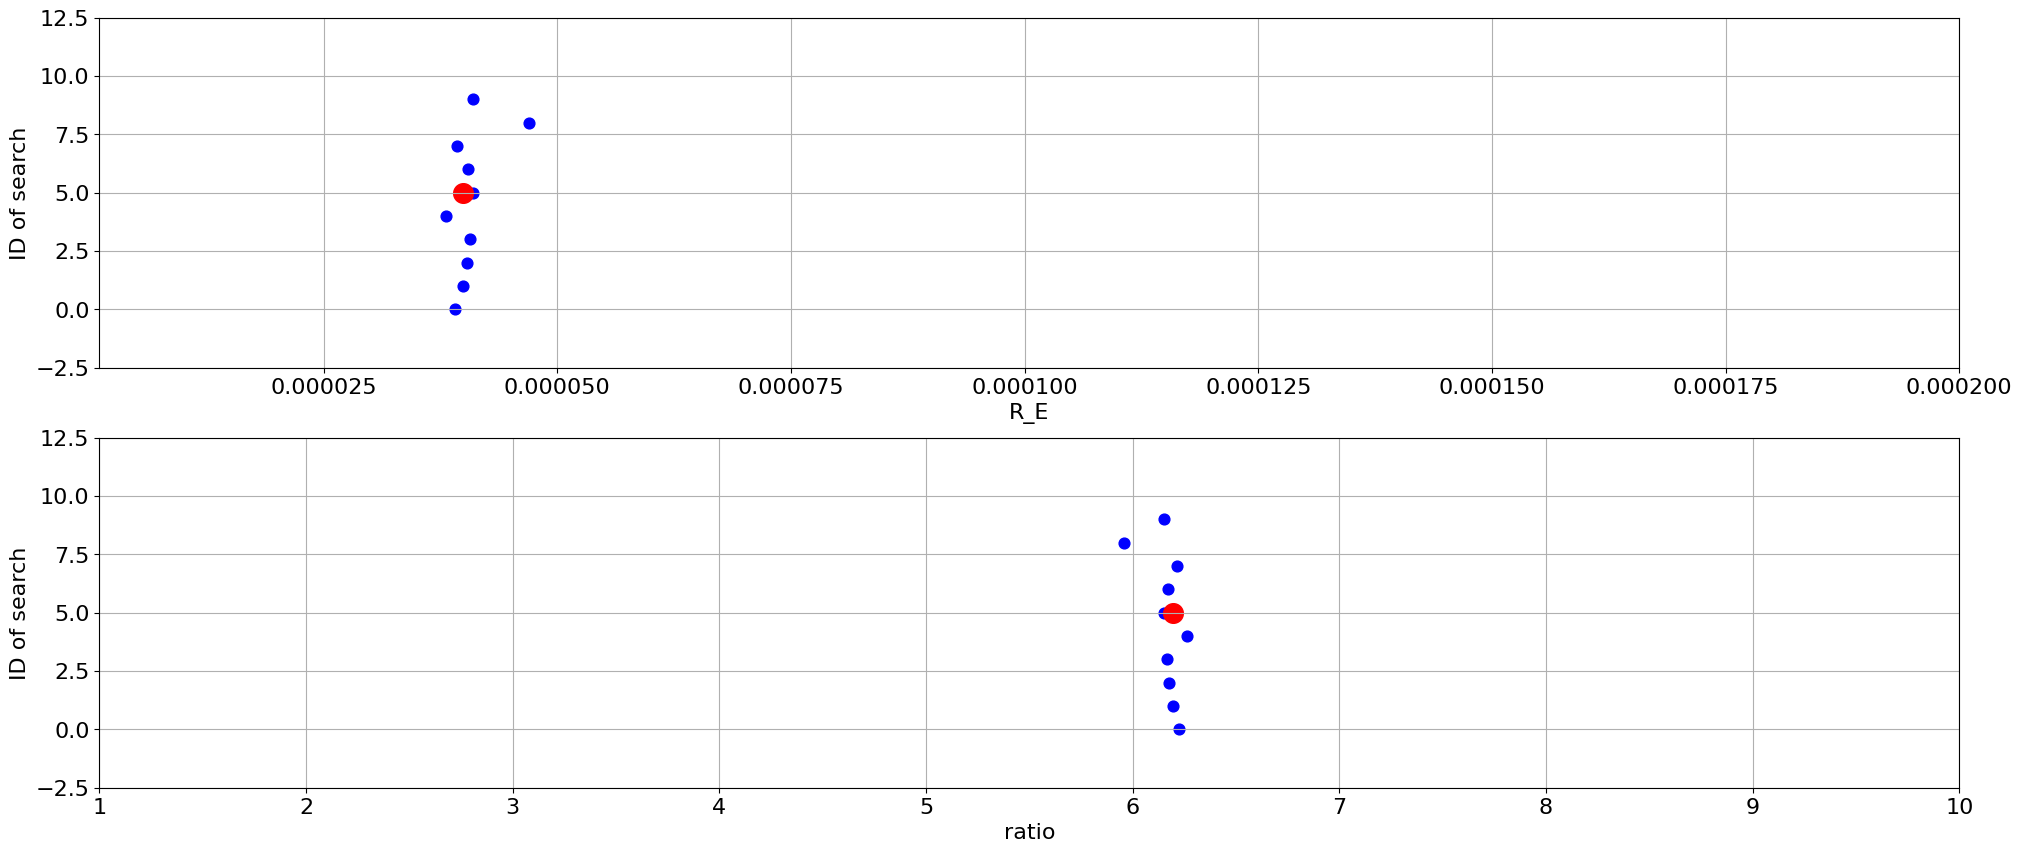

In [11]:
"""Plot the distribution of the optimums"""

best_output = min([x[-1] for x in to_plot])

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.25*n, 1.25*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
